# Play with TorchVision's Faster RCNN Implementation

In [1]:
from torchvision.io.image import decode_image
from torchvision.models.detection import (
    fasterrcnn_resnet50_fpn_v2,
    FasterRCNN_ResNet50_FPN_V2_Weights,
)
from torchvision.utils import draw_bounding_boxes
from torchvision.transforms.functional import to_pil_image

/home/tf/anaconda3/envs/pytorch-cu124/lib/python3.11/site-packages/torchvision/utils.py:225: UserWarning: Argument 'font_size' will be ignored since 'font' is not set.
  warnings.warn("Argument 'font_size' will be ignored since 'font' is not set.")


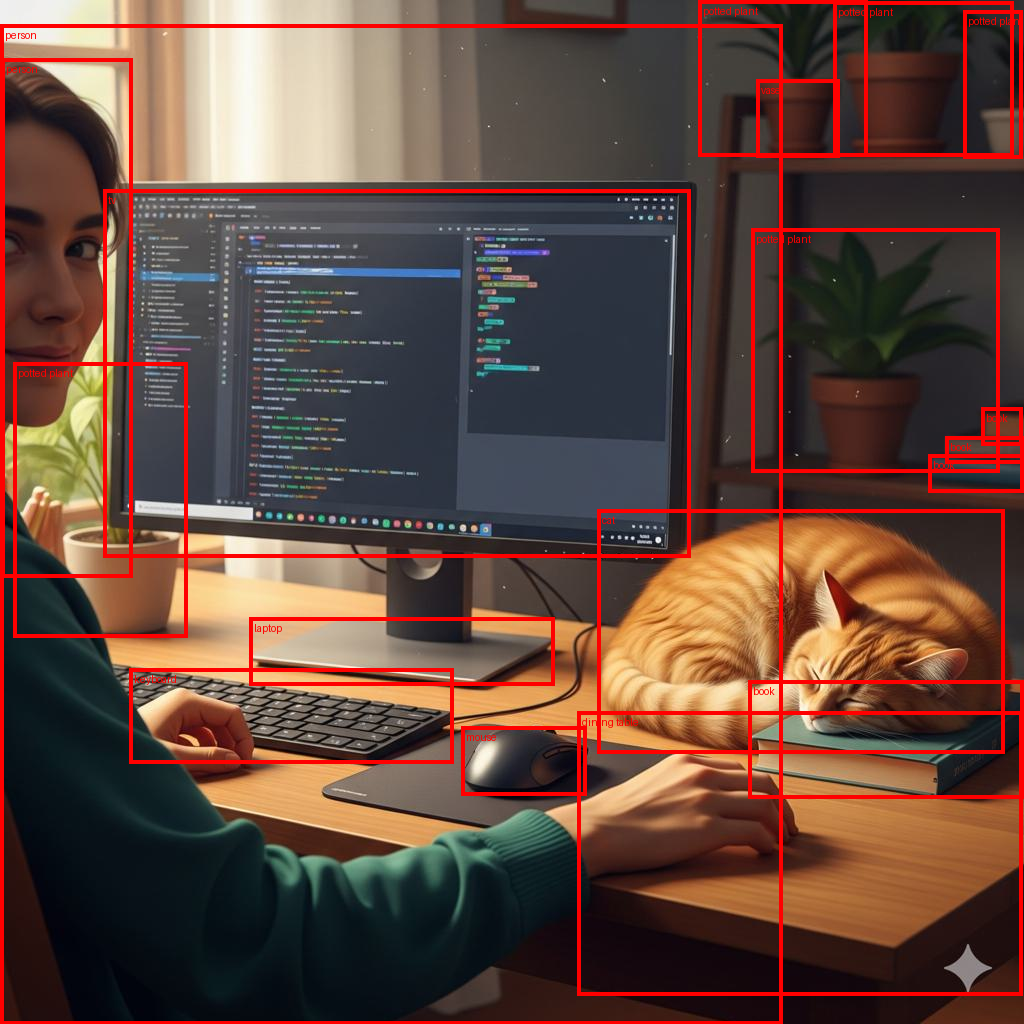

In [2]:
from networkx import draw
from spacy.lang.lij.tokenizer_exceptions import prep


img = decode_image("./resources/fasterrcnn_test.jpg")

# Step 1: Initialize the model with pre-trained weights
weights = FasterRCNN_ResNet50_FPN_V2_Weights.DEFAULT
model = fasterrcnn_resnet50_fpn_v2(
    weights=weights, box_score_thresh=0.5, box_nms_thresh=0.3
)
model.eval()

# Step 2: Initialize inference transforms
preprocess = weights.transforms()

# Step 3: Apply inference preprocessing transforms
batch = [preprocess(img)]

# Step 4: Use the model and visualize the predictions
prediction = model(batch)[0]

labels = [weights.meta["categories"][i] for i in prediction["labels"]]

box = draw_bounding_boxes(
    img, boxes=prediction["boxes"], labels=labels, colors="red", width=4, font_size=30
)
to_pil_image(box.detach())

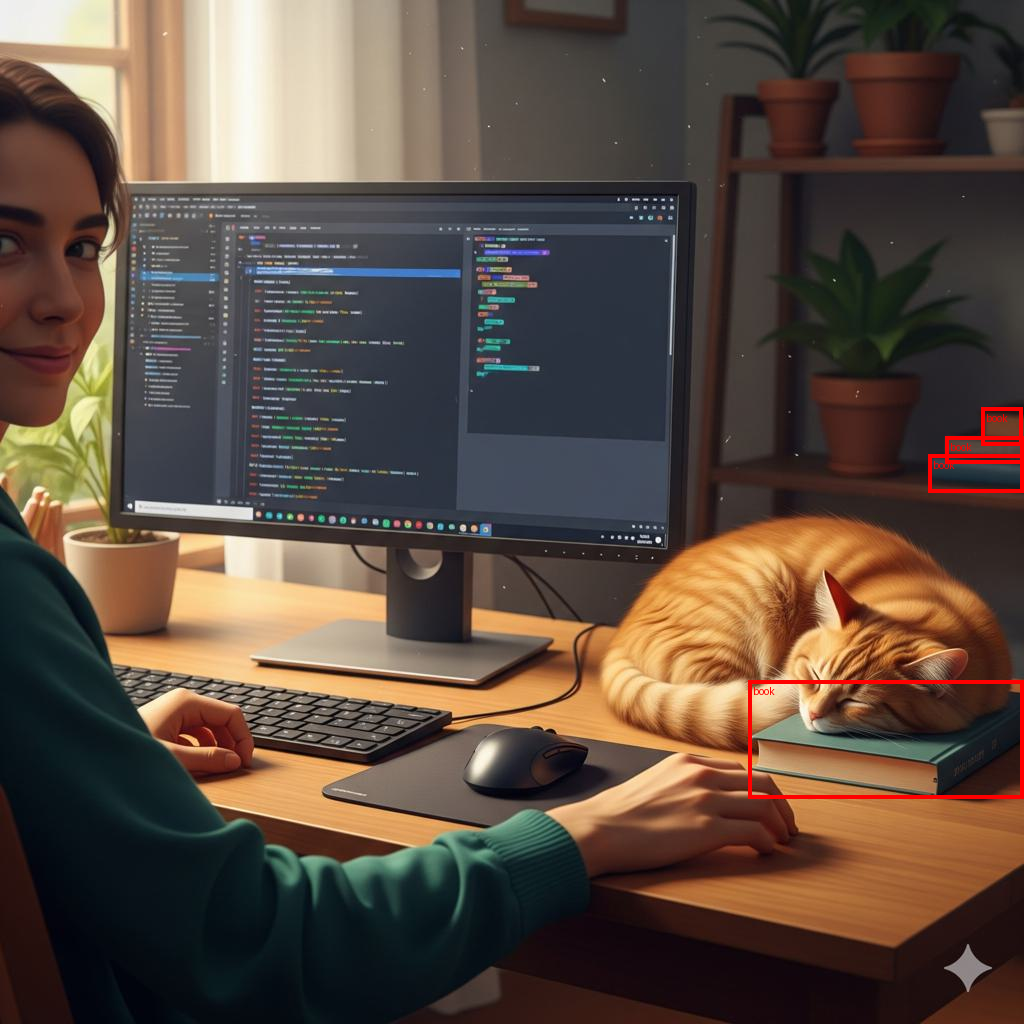

In [3]:
def select_prediction_of_specific_class(prediction, class_name):
    labels = prediction["labels"].tolist()
    boxes = prediction["boxes"]

    selected_box_indices = []

    for i, label in enumerate(labels):
        if weights.meta["categories"][label] == class_name:
            selected_box_indices.append(i)

    return boxes[selected_box_indices], [class_name] * len(selected_box_indices)


boxes, labels = select_prediction_of_specific_class(prediction, "book")
box = draw_bounding_boxes(
    img, boxes=boxes, labels=labels, width=4, font_size=30, colors="red"
)
to_pil_image(box)

## Backbone Utils

Torchvision的Backbone支持mobilenet和resnet作为backbone，同时这些backbone都支持FPN(Feature Paramid Neural).

In [4]:
import torch
from torchvision.models import ResNet50_Weights
from torchvision.models.detection.backbone_utils import resnet_fpn_backbone
import rich


backbone = resnet_fpn_backbone(
    backbone_name="resnet50", weights=ResNet50_Weights.DEFAULT, trainable_layers=3
)

x = torch.rand(1, 3, 256, 256)
output = backbone(x)
rich.print([(k, v.shape) for k, v in output.items()])

[
    ('0', torch.Size([1, 256, 64, 64])),
    ('1', torch.Size([1, 256, 32, 32])),
    ('2', torch.Size([1, 256, 16, 16])),
    ('3', torch.Size([1, 256, 8, 8])),
    ('pool', torch.Size([1, 256, 4, 4]))
]

In [5]:
from torchview import draw_graph

model_graph = draw_graph(model, input_size=(1, 3, 256, 256))
model_graph.visual_graph

ExecutableNotFound: failed to execute PosixPath('dot'), make sure the Graphviz executables are on your systems' PATH